# Algorytm Genetyczny - Rozwiązujący - Problem Komiwojażera
### Problematyka: 
<div> Problem komiwojażera to klasyczne zadanie optymalizacyjne, które polega na znalezieniu najkrótszej trasy łączącej zbiór punktów (np. miast), </div>
<div> przy założeniu, że odwiedzimy każdy punkt dokładnie raz i wrócimy do punktu wyjścia. </div>
<div> Problem definiowany jest jako NP-trudny, zwłaszcza dla większych zbiorów punktów, ponieważ liczba możliwych kombinacji rośnie wykładniczo wraz z liczbą punktów.</div>
<div> </div>
~ Tymoteusz Morawiec

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import itertools

In [4]:
def generate_random_points(N, x_range, y_range): # Generowanie miast
    points = []
    for _ in range(N):
        x = random.uniform(x_range[0], x_range[1])
        y = random.uniform(y_range[0], y_range[1])
        points.append((x, y))
    return points

In [5]:
def euclidean_distance(point1, point2): # Funckja dystansu euklidesowego
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_distance_matrix(points): # Funkcja jakości 
    n = len(points)
    distance_matrix = [[0] * n for _ in range(n)]
    
    for i in range(n):
        for j in range(i+1, n):
            distance = euclidean_distance(points[i], points[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    
    return distance_matrix

In [6]:
def generate_unique_permutations(n, m): # Tworzenie populacji
    initial_vector = list(range(n))
    unique_permutations = []
    while len(unique_permutations) < m:
        new_vector = np.random.permutation(initial_vector).tolist()
        if new_vector not in unique_permutations:
            unique_permutations.append(new_vector)
        
    return pd.DataFrame(unique_permutations)

In [7]:
def calculate_total_distance(order, distance_matrix): # Funckja pomocnicza, służy do liczenia długosci konktretnej trasy
    total_distance = 0
    n = len(order)
    for i in range(n - 1):
        total_distance += distance_matrix[order[i]][order[i+1]]
    total_distance += distance_matrix[order[-1]][order[0]]
    
    return total_distance

In [8]:
def calculate_distances_for_population(population, distance_matrix): # Funkcja jakości, liczy 'dlugosc trasy' dla danej populacji
    distances = []
    result = population.copy()
    for _, row in population.iterrows():
        order = row.tolist()
        distance = calculate_total_distance(order, distance_matrix)
        distances.append(distance)
    result['Distance'] = distances
    return result

In [9]:
def best_route(populacja_z_ocena): # Zwraca najlepszą trasę w populacji
    return populacja_z_ocena.sort_values('Distance', ascending=True).head(1).drop('Distance', axis=1).iloc[0].values.tolist()

In [10]:
def best_route_distance(populacja_z_ocena): #  Zwraca długość najlepszej trasy w populacji
    return float(populacja_z_ocena.sort_values('Distance',ascending=True).head(1)['Distance'])

In [11]:
def selection(populacja_z_ocena,m): # Twarda Ewolucja, metoda rankingowa, wybieramy 50 %, najelpszych osobników, by z nich skrzyżować potomostwo
    return populacja_z_ocena.sort_values('Distance',ascending=True).head(int(m/4)).drop('Distance',axis=1)

In [12]:
def cross(rodzice,m,): # Funckja krzyżowania rodziców, by otrzymać populacje potomków
    potomstwo = []
    
    while len(potomstwo) < m - len(rodzice): # Nowa populacja składa się z skrzyżowanych chromosomów oraz osobników ze starej populacji
        
        r1 = list(rodzice.sample(1).iloc[0])
        r2 = list(rodzice.sample(1).iloc[0])
        n = len(r1)
        gen_start = np.random.randint(0,n)
        gen_stop = np.random.randint(gen_start,n)

        wycinek = r1[gen_start:gen_stop+1]
        
        for gen in wycinek:
            r2.remove(gen)
        
        potomek = []
        potomek = r2[:gen_start+1] + wycinek + r2[gen_start+1:]
        
        potomstwo.append(potomek)
    potomstwo = pd.DataFrame(potomstwo, columns=rodzice.columns) 
    potomstwo = pd.concat([potomstwo,rodzice])
    return potomstwo

In [13]:
def mutate(population, mutation_rate=0.15): # Funckja mutowania chromosomu
    mutated_population = []
    
    for vector in population.values: # Dla każdego chromosomu w danej populacji
        if random.random() < mutation_rate: # Z szansą mutation_rate
            index1, index2 = random.sample(range(len(vector)), 2)  # Dokonujemy zamiany miejsc randomowo ybranych genów
            
            vector[index1], vector[index2] = vector[index2], vector[index1]
        
        mutated_population.append(vector)
    
    return pd.DataFrame(mutated_population, columns=population.columns)

## Algorytm genetyczny
### Parametry:
- n - ilość miast
- m - wielkość populacji
- x_range - zakres x
- y_range - zakres y
#### Dodatkowy Parametr Testowy:
- radius - promień okręgu

### Etapy działania algorytmu

1. Generujemy punkty ( miasta )

2. Generujemy macierz odległości ( funkcja jakości )

3. Losujemy populację początkową

4. Oceniamy populację początkową

5. Pętla:
   1. Dokonujemy selekcji 25% najlepszych osobników z populacji rodziców
   2. Dokoknujemy krzyżowania najlepszych osobników z czego dostajemy 75% nowej populacji, pozostałe 25% to najlepsi rodzice
   3. Następnie dokonujemy mutacji nowej populacji
   4. Najlepszą trasę wrzucamy do tablicy najlepszych loklanych rozwiązań

Pętla kończy pracę po osiągnięciu optymalnej wartości ( Obwód okręgu ) lub gdy dojdziemy do tysięcznego pokolenia

### Test Case
- użyjemy puntków z okręgu

In [85]:
def generate_points_on_circle(num_points, x_center, y_center, radius):
    thetas = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    x_values = x_center + radius * np.cos(thetas)
    y_values = y_center + radius * np.sin(thetas)
    points = list(zip(x_values, y_values))
    return points
def plot_points_with_paths(N,x_range, y_range, points,ax, best_local_route=None):
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]
    sns.scatterplot(x=x_values, y=y_values, color='black')
    
    if best_local_route:
        x_path = [points[i][0] for i in best_local_route]
        y_path = [points[i][1] for i in best_local_route]
        ax.plot(x_path, y_path, color='m', linestyle='-', linewidth=2)
        
    plt.title("Optymalna Trasa")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim([x_range[0], x_range[1]])
    plt.ylim([y_range[0], y_range[1]])
    plt.show()


In [86]:
def genetic_algorithm(points,N,M,optimal_value=None):
    distance_matrix = calculate_distance_matrix(points)
    populacja = pd.DataFrame(generate_unique_permutations(N,M)) # Tworzenie populacji
    populacja.index.name = 'm'
    populacja_ocena = calculate_distances_for_population(populacja,distance_matrix) # Pierwsza Ocena Populacji
    
    best_local_route_distance = []
    best_local_route_distance.append(best_route_distance(populacja_ocena)) # Dodanie najbardziej optymalnej lokalnej trasy
    maksymalne_pokolenie = 0
    
    while best_local_route_distance[-1] > optimal_value and maksymalne_pokolenie < 1000: # Warunki stopu
        maksymalne_pokolenie += 1
        najlepsze_osobniki = selection(populacja_ocena,m) # Selekcja rankingowa
        potomostwo = cross(najlepsze_osobniki,m) # Krzyżowanie rodziców, tworzenie nowego pokolenia
        zmutowane_potomstwo = mutate(potomostwo) # Operacja mutacji na potomostwie
        populacja_ocena = calculate_distances_for_population(zmutowane_potomstwo,distance_matrix) # Ocena Populacji
        best_local_route_distance.append(best_route_distance(populacja_ocena))

    
    best_path = best_route(populacja_ocena)
    # Wykresy
    sns.set_style("darkgrid")
    fig,ax = plt.subplots(1,2,figsize = (8,5))
    pd.DataFrame(best_local_route_distance).plot(ax=ax[0],title=f'N: {N}, M: {M}')
    ax[0].set_xlabel('pokolenie')
    ax[0].set_ylabel('długość trasy')
    if optimal_value != None:
        ax[0].axhline(y=optimal_value, color='r', linestyle='--', label='Optimal Value')
    plot_points_with_paths(n,x_range,y_range,points,ax[1],best_path)
    plt.show()
    #return [best_path,best_local_route_distance]

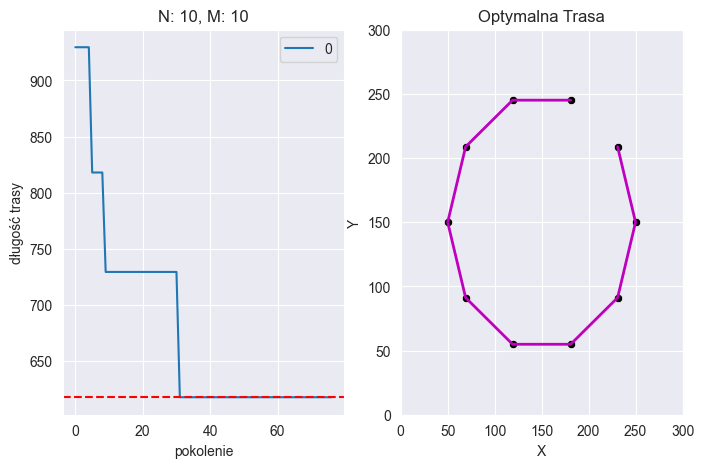

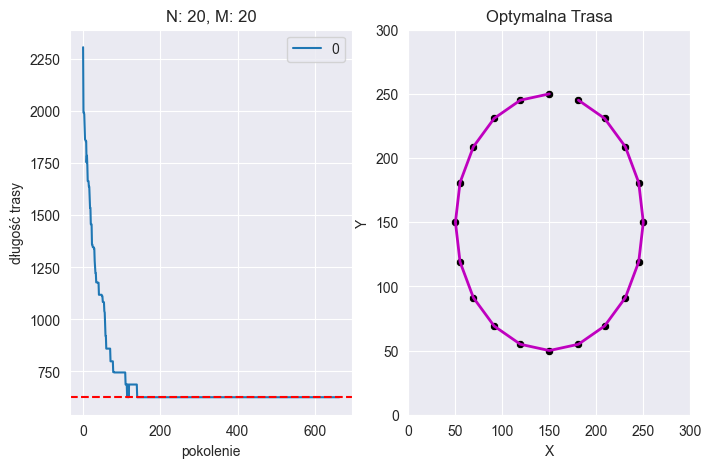

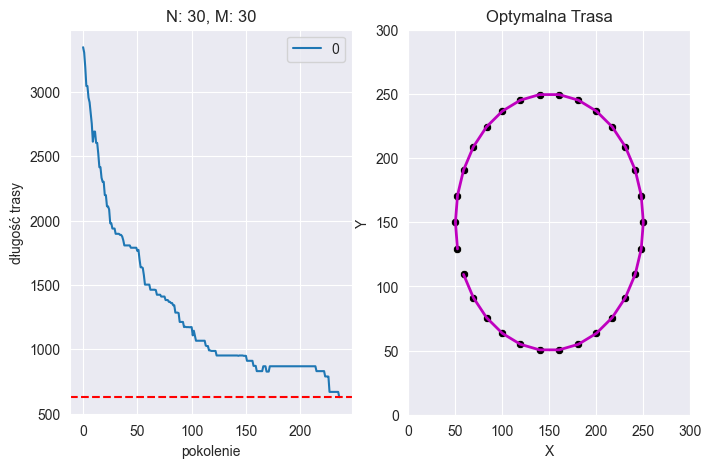

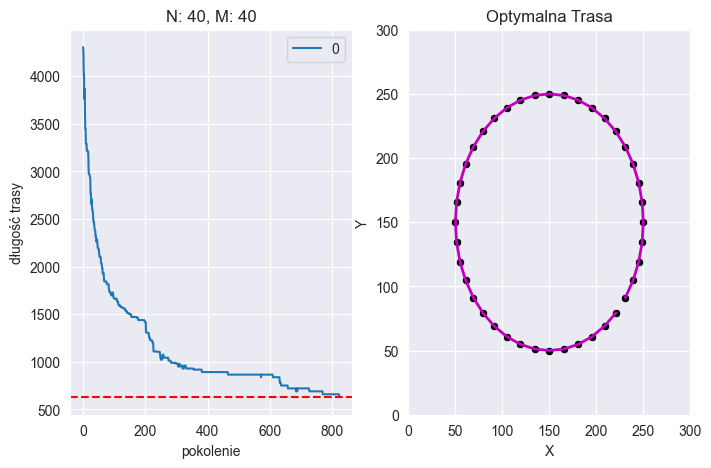

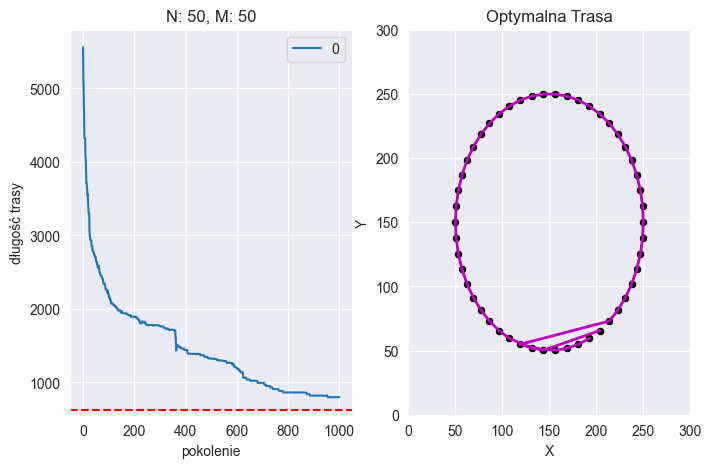

In [88]:
n = 30
m = 50
x_range = (0, 300)
y_range = (0, 300)
radius = 100

for i in range(1,6):
    n = 10 * i
    m = 10 * i
    x_center = (x_range[1] - x_range[0])/2 
    y_center = (y_range[1] - y_range[0])/2 
    
    circle_points = generate_points_on_circle(n, x_center, y_center, radius)
    distance_matrix = calculate_distance_matrix(circle_points)
    order = list(range(n))
    minimal_value_circle = calculate_total_distance(order, distance_matrix)
    optimal_value = minimal_value_circle * 1 # Wartość, którą chcemy osiągnąć
    genetic_algorithm(circle_points,n,m,optimal_value)

In [92]:
def genetic_algorithm(points,N,M,mutation_rate=0.15,optimal_value=None):
    distance_matrix = calculate_distance_matrix(points)
    populacja = pd.DataFrame(generate_unique_permutations(N,M)) # Tworzenie populacji
    populacja.index.name = 'm'
    populacja_ocena = calculate_distances_for_population(populacja,distance_matrix)
    
    best_local_route_distance = []
    best_local_route_distance.append(best_route_distance(populacja_ocena))
    maksymalne_pokolenie = 0
    
    while maksymalne_pokolenie < 1000:
        maksymalne_pokolenie += 1
        najlepsze_osobniki = selection(populacja_ocena,m)
        potomostwo = cross(najlepsze_osobniki,m)
        zmutowane_potomstwo = mutate(potomostwo,mutation_rate)
        populacja_ocena = calculate_distances_for_population(zmutowane_potomstwo,distance_matrix)
        best_local_route_distance.append(best_route_distance(populacja_ocena))

    
    best_path = best_route(populacja_ocena)
    # Wykresy
    fig,ax = plt.subplots(1,2,figsize = (15,8))
    pd.DataFrame(best_local_route_distance).plot(ax=ax[0],title=f'N: {N}, M: {M}')
    ax[0].set_xlabel('pokolenie')
    ax[0].set_ylabel('długość trasy')
    if optimal_value != None:
        ax[0].axhline(y=optimal_value, color='r', linestyle='--', label='Optimal Value')
    plot_points_with_paths(n,x_range,y_range,points,ax[1],best_path)
    plt.show()
    #return [best_path,best_local_route_distance]

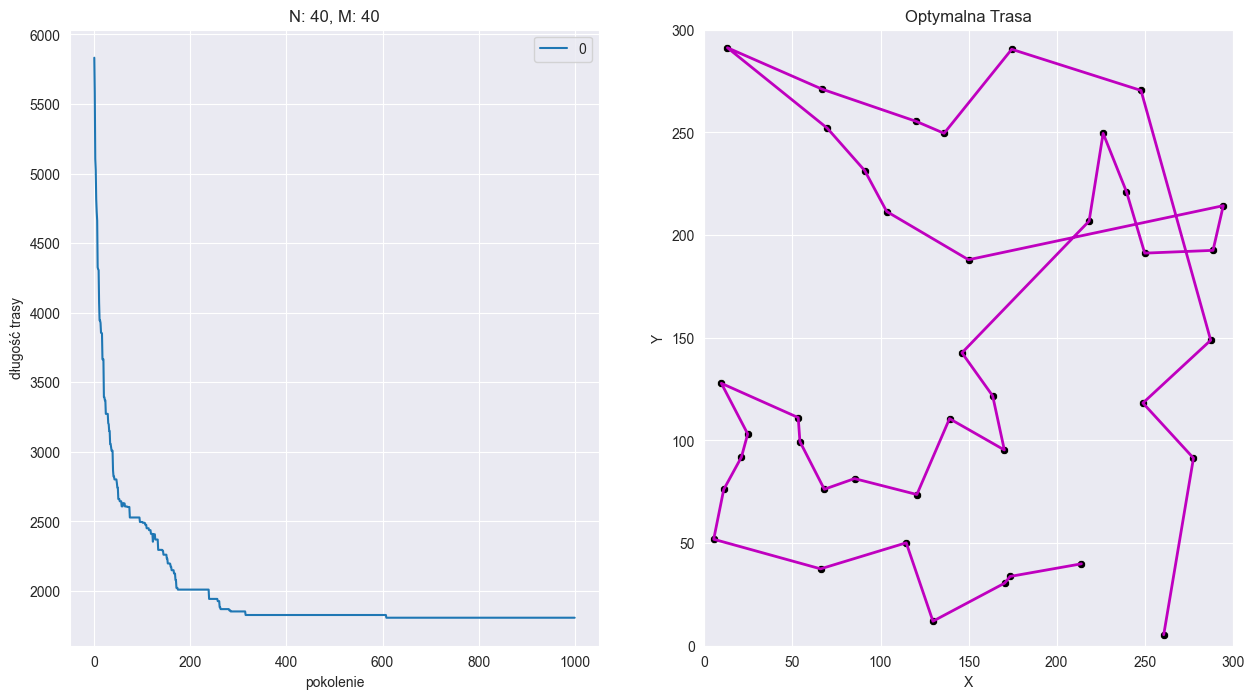

In [93]:
n = 40
m = 40
x_range = (0, 300)
y_range = (0, 300)
mutation_rate = 1/m
points = generate_random_points(n,x_range,y_range)
genetic_algorithm(points,n,m,mutation_rate)


### Wnioski:
 - Bazując o wyniki Test Case'u, można założyć, że algorytm działa całkowicie poprawnie, ponieważ znajduje optymalne trasy dla n <= 40
 - Przy n == 50, niesety nie znajduje optymalnej trasy. Powodem może być wiele rzeczy. Pierwszą, która się narzuca to za niska wartość maksymalnej ilości pokoleń, ponieważ funckja ciągle malała pod koniec.
 - Ale może to być również spowodowane innymi parametrami, jak procent osobników wybieranych przy selekcji, szansa na mutację, lub ilość chromosomów w pokoleniu
 - Ostatecznie, dochodzę do wniosku, że algorytm działa poprawnie, aczkolwiek otrzymanie optymalnej trasy wymaga dostosowywania parametrów do danego przypadku

<div></div>
<div> Dziękuję za uwagę i pozdrawiam, Tymoteusz Morawiec </div>